Data Description : Imagine being hungry in an unfamiliar part of town and getting restaurant recommendations served up, based on your personal preferences, at just the right moment. The recommendation comes with an attached discount from your credit card provider for a local place around the corner!

Right now, Elo, one of the largest payment brands in Brazil, has built partnerships with merchants in order to offer promotions or discounts to cardholders. But do these promotions work for either the consumer or the merchant? Do customers enjoy their experience? Do merchants see repeat business? Personalization is key.

Elo has built machine learning models to understand the most important aspects and preferences in their customers’ lifecycle, from food to shopping. But so far none of them is specifically tailored for an individual or profile. This is where you come in.

In this competition, Kagglers will develop algorithms to identify and serve the most relevant opportunities to individuals, by uncovering signal in customer loyalty. Your input will improve customers’ lives and help Elo reduce unwanted campaigns, to create the right experience for customers.

![](https://storage.googleapis.com/kaggle-competitions/kaggle/10445/logos/thumb76_76.png?t=2018-10-24-17-14-05)

Reference 
- https://www.kaggle.com/youhanlee/hello-elo-ensemble-will-help-you
- https://www.kaggle.com/ashishpatel26/beginner-guide-of-elo-eda-kfold-lightgbm
- https://www.kaggle.com/kailex/tidy-elo-starter-3-813
- https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo

### Simple Exploration

In [1]:
# Loading packages
import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc


- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format - contains all card_ids you are expected to predict for.
- historical_transactions.csv - up to 3 months' worth of historical transactions for each card_id
- merchants.csv - additional information about all merchants / merchant_ids in the dataset.
- new_merchant_transactions.csv - two months' worth of data for each card_id containing ALL purchases that card_id made at merchant_ids that were not visited in the historical data.

In [2]:
train = pd.read_csv("train.csv", parse_dates=["first_active_month"])
print("shape of train : ",train.shape)

shape of train :  (201917, 6)


In [3]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


- first_active_month : ''YYYY-MM', month of first purchase
- feature_1,2,3 : Anonymized card categorical feature
- target : Loyalty numerical score calculated 2 months after historical and evaluation period

In [4]:
test = pd.read_csv("test.csv", parse_dates=["first_active_month"])
print("shape of test : ",test.shape)

shape of test :  (123623, 5)


In [5]:
import datetime

for df in [train,test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['year'] = df['first_active_month'].dt.year
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days

#del train['target']

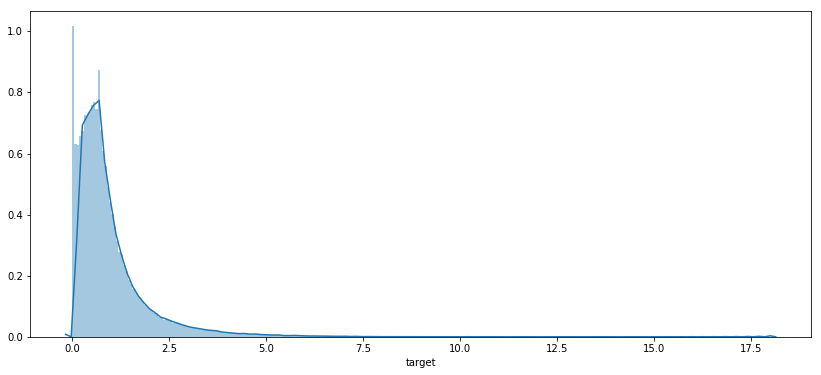

In [6]:
#histogram
#We will fit directly to this and then backtransform 

#SO we transfrom our predictions back with htis transformation
def backttransform(x):
    return np.log(np.exp(x)-1)
#do put the targe tot hte better log scale
def log_correction(x):
    return np.log(np.exp(x)+1)

target = train['target']

f, ax = plt.subplots(figsize=(14, 6))
sns.distplot(log_correction(target),bins=300)


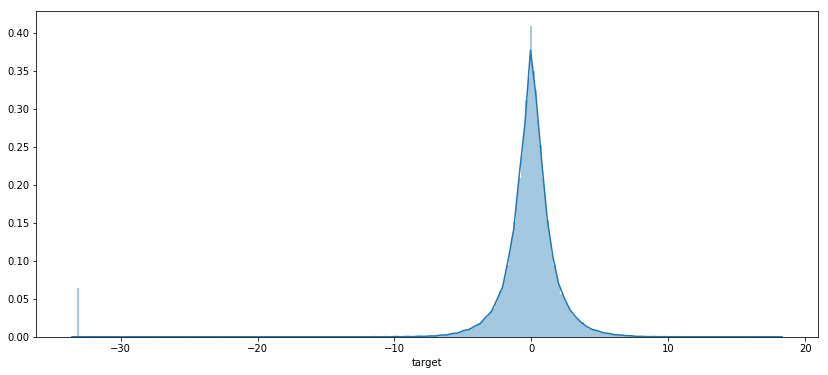

In [7]:
#And then use the backtransform to get ot the correct distribution for evaluation 
f, ax = plt.subplots(figsize=(14, 6))
#Checking that backtransform works
sns.distplot(backttransform(log_correction(target)),bins=300)

### Missing value NOT A PROBLEM

In [8]:
#Get Historical Transactions data 
ht = pd.read_csv("historical_transactions.csv")
print("shape of historical_transactions : ",ht.shape)
#For some reason they put in the New merchants transaction in a different data frame? 
ht_new_merchants = pd.read_csv("new_merchant_transactions.csv")
print("shape of new_merchant_transactions : ",ht_new_merchants.shape)
#ht_new_merchants.head()

#just put them together There is really no need to seperate the transactions like this :D
ht=pd.concat([ht,ht_new_merchants],axis=0)


shape of historical_transactions :  (29112361, 14)
shape of new_merchant_transactions :  (1963031, 14)


### Simple Exploration : historical_transactions

In [9]:
#Get merchant data remove duplicates
merchant = pd.read_csv("merchants.csv")
print("shape of merchant : ",merchant.shape)
merchant=merchant[-merchant.merchant_id.duplicated()]

shape of merchant :  (334696, 22)


In [10]:
#getting rid of the infs. 
#removing NAS
merchant=merchant[-merchant["avg_sales_lag3"].isna()]
#remove infs
merchant=merchant[merchant["avg_purchases_lag3"]<10000000]


In [11]:
#We integer code before mergin, this way we can differentiate the "normal NA " with the NA introduced by the merging 
def integer_code(data_frame,col):
    data_frame[col] = data_frame[col].map(dict(zip(data_frame[col].unique(),range(1,len(data_frame[col].unique())+1))))

#Integer coding ht  
ht_categorical_names=['authorized_flag','city_id','category_1'
                 ,'installments','category_3','merchant_category_id','month_lag',"category_2", 'state_id','subsector_id']


In [12]:
for cats in ht_categorical_names:
    integer_code(ht,cats)

In [13]:
mt_categorical_names=['merchant_group_id','merchant_category_id','subsector_id','category_1'
                 ,'most_recent_sales_range','most_recent_purchases_range', 'active_months_lag3', 'active_months_lag6', 'active_months_lag12',
       'category_4', 'city_id', 'state_id', 'category_2']

#ht_categorical_frame=ht[ht_categorical_names+ht_id]
for cats in mt_categorical_names:
    integer_code(merchant,cats)


In [14]:
#we merge transaction wiht merchant information, all transactions merge, no NAs
ht=ht.merge(merchant,left_on="merchant_id",right_on="merchant_id",how="left")
#There are NA's introduced by the merging operation ( for some merchants there is not "merchant info ") makes sense, il put them to 0 
ht=ht.fillna(0)


In [15]:
#x is from left while y is from the right, y is the "reference" merchant case, while x is the actuall merhcant info present which can e
#be different: 
ht=ht.drop(columns=["merchant_category_id_y","subsector_id_y","category_1_y", 'city_id_y', 'state_id_y',#'city_id_x', 'category_1_x',"merchant_category_id_x","category_2_x","state_id_x","subsector_id_x"

       'category_2_y'])


In [16]:
#Collect them 
cat_frame_ht=ht[['authorized_flag', 'card_id', 'city_id_x', 'category_1_x',
       'installments', 'category_3', #'merchant_category_id_x',
       'month_lag', 'purchase_date', 'category_2_x',
       'state_id_x', 'subsector_id_x', 'merchant_group_id',
        'most_recent_sales_range', 'most_recent_purchases_range',
       'active_months_lag3',
        'active_months_lag6',
        'active_months_lag12',
       'category_4']]

def fun_c(x):
    x=x.sort_values(by='purchase_date')
    x=x.drop(columns=["card_id","purchase_date"])
    return x.values
#Grouping Categoricals .apply(lambda x: x.drop(columns=["card_id"]).values)
grps_cat_ht=cat_frame_ht.groupby("card_id",as_index=True).apply(lambda x: fun_c(x))

#Merging Categoricals
train=train.merge(grps_cat_ht.to_frame(), right_index=True,left_on="card_id")
train=train.rename(index=str, columns={0: "categoricals_ht"})

In [17]:

num_frame_ht=ht[[ 'card_id', 'purchase_date','avg_sales_lag3', 'avg_purchases_lag3','avg_sales_lag6', 'avg_purchases_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12',"numerical_1","numerical_2","purchase_amount"]]

exlude=["card_id", 'purchase_date']

In [18]:
#log scale an normalize all needed collumns 
for var in [item for item in num_frame_ht.columns if item not in exlude]:
    num_frame_ht[var]=np.log(num_frame_ht[var]+1)/np.max(np.log(num_frame_ht[var]+1))

In [19]:
#Grouping numericals .apply(lambda x: x.drop(columns=["card_id"]).values)
num_frame_ht=num_frame_ht.groupby("card_id",as_index=True).apply(lambda x: fun_c(x))

In [20]:
#Merging numericals
train=train.merge(num_frame_ht.to_frame(), right_index=True,left_on="card_id")


In [21]:
train=train.rename(index=str, columns={0: "numericals_ht"})

In [22]:
train["elapsed_time"]=train["elapsed_time"]/max(train["elapsed_time"])

In [23]:
#integer code the fixed length categorical info  
integer_code(train,"year")
integer_code(train,"month")
integer_code(train,"feature_1")
integer_code(train,"feature_2")
integer_code(train,"feature_3")
del train["card_id"]
del train["first_active_month"]

In [24]:
#collect all variable names ( for model set up and for returning values correctly in dict ) Num names are not needed
num_names=['avg_sales_lag3', 'avg_purchases_lag3','avg_sales_lag6', 'avg_purchases_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12',"numerical_1","numerical_2","purchase_amount"]

cat_names=['authorized_flag', 'city_id_x', 'category_1_x',
       'installments', 'category_3', #'merchant_category_id_x',
       'month_lag', 'category_2_x',
       'state_id_x', 'subsector_id_x', 'merchant_group_id',
        'most_recent_sales_range', 'most_recent_purchases_range',
       'active_months_lag3',
        'active_months_lag6',
        'active_months_lag12',
       'category_4']
cat_names_hl=["feature_1","feature_2","feature_3","year","month"]

In [25]:
#to put in on the last location 
target = train['target']
del train["target"]
train["target"] = log_correction(target.values)

In [26]:
#train["target"]=log_correction(train["target"])

In [27]:
from sklearn.model_selection import train_test_split
train_,test_=train_test_split(train)

In [28]:
from random import shuffle

In [29]:

batch_size=128
index = 1

batch_idx=range(index*int(batch_size),(index+1)*int(batch_size))
batch_idx

range(128, 256)

In [112]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_frame, batch_size=32):
        'Initialization'
        #the dataframe as a numpy array
        self.data_frame = data_frame
        self.batch_size = batch_size

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.data_frame.shape[0] / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        '''
        Multi Level Batch Generator with dynamic padding 

        '''
        #index=0
        batch_idx=range(index*int(self.batch_size),(index+1)*int(self.batch_size))

        batch_fl_cat=self.data_frame[batch_idx,0:5]
        batch_fl_nm=self.data_frame[batch_idx,5]
        batch_cat=self.data_frame[batch_idx,6]
        batch_num=self.data_frame[batch_idx,7]
        batch_target=self.data_frame[batch_idx,8]
        
        
        #get max length for padding 
        ml=np.max([x.shape[0] for x in batch_cat])
        Z_c = np.zeros((self.batch_size,ml,16))
        Z_n = np.zeros((self.batch_size,ml,9))

        #Dynamic padding tada!
        for enu,grps in enumerate(zip(batch_cat.tolist(),batch_num.tolist())):
            grps_c=grps[0]
            grps_n=grps[1]
            #print(grps_c.shape)
            #print(grps_n.shape)
            rows=grps_c.shape[0]
            Z_c[enu,0:rows,:]=grps_c
            Z_n[enu,0:rows,:]=grps_n

        #Split first level info 
        cat_splits=np.split(Z_c,16,axis=2)
        cat_splits=[np.squeeze(x) for x in cat_splits]

        #split high level info 
        cat_splits_fl=np.split(batch_fl_cat,5,axis=1)
        cat_splits_fl=[np.squeeze(x) for x in cat_splits_fl]

        #Finally supply all of the data 
        cat_return_dict=dict(zip(cat_names,cat_splits))
        num_return_dict={"numericals":Z_n}
        cat_return_dict_hl=dict(zip(cat_names_hl,cat_splits_fl))
        num_return_dict_hl={"numericals_hl":batch_num}
        
        final_dict={}
        final_dict.update(cat_return_dict)
        final_dict.update(num_return_dict)
        final_dict.update(cat_return_dict_hl)
        final_dict.update(num_return_dict_hl)
        
        return final_dict,batch_target

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        #shuffle(self.data_frame)

In [113]:
shuffle??
#shuffle(train_.values)

In [114]:
train_.values[:,8]

array([0.35058442126853323, 0.24308857515830065, 0.09654384647886835, ...,
       0.5726196777177793, 0.45141486959517446, 0.4447344950058478],
      dtype=object)

In [115]:
train_.values[:,8]

array([0.35058442126853323, 0.24308857515830065, 0.09654384647886835, ...,
       0.5726196777177793, 0.45141486959517446, 0.4447344950058478],
      dtype=object)

In [116]:
#train_["target"]

In [117]:
ma=np.max(train_["target"])

In [167]:
ma

17.965068415771388

In [168]:
train_["target"]=train_["target"]/ma

In [169]:
test_["target"]=test_["target"]/ma

In [172]:
#setting up all the categorical models
from keras.layers import Embedding, Dense, CuDNNGRU,Input,Concatenate,GlobalAveragePooling1D,GlobalMaxPooling1D,BatchNormalization
from keras import Model

In [173]:
input_dim_cat=np.max(ht[['authorized_flag', 'city_id_x', 'category_1_x',
       'installments', 'category_3', #'merchant_category_id_x',
       'month_lag', 'category_2_x',
       'state_id_x', 'subsector_id_x', 'merchant_group_id',
        'most_recent_sales_range', 'most_recent_purchases_range',
       'active_months_lag3',
        'active_months_lag6',
        'active_months_lag12',
       'category_4']]).tolist()

In [174]:
cat_names

['authorized_flag',
 'city_id_x',
 'category_1_x',
 'installments',
 'category_3',
 'month_lag',
 'category_2_x',
 'state_id_x',
 'subsector_id_x',
 'merchant_group_id',
 'most_recent_sales_range',
 'most_recent_purchases_range',
 'active_months_lag3',
 'active_months_lag6',
 'active_months_lag12',
 'category_4']

In [175]:
input_dim_cat_hl=np.max(train_[["feature_1","feature_2","feature_3","year","month"]])

In [263]:
input_list=[]
for cat in cat_names:
    input_list.append(Input(shape=(None,),name=cat))

In [264]:
output_dim_cat=[]

In [265]:
def emb_code(x):
    log_x=np.log(x)
    if log_x < 2:
        return 2
    else:
        return int(log_x)

In [266]:
for i,j in enumerate(input_dim_cat):
    output_dim_cat.append(emb_code(j))

In [267]:
output_dim_cat #,embeddings_regularizer=keras.regularizers.l2(0.00001)

[2, 5, 2, 2, 2, 2, 2, 3, 3, 11, 2, 2, 2, 2, 2, 2]

In [268]:
embed_list=[]
for j,elem in enumerate(input_list):
    embed_list.append(Embedding(input_dim=int(input_dim_cat[j]+2),output_dim=output_dim_cat[j]
                                )(elem))

In [269]:
numerical_input=Input(shape=(None,9),name="numericals")

In [270]:
all_cat_features=Concatenate()(embed_list+[numerical_input])

In [271]:
feature=CuDNNGRU(128,return_sequences=True)(all_cat_features)
feature=CuDNNGRU(128,return_sequences=True)(feature)
#feature=Dense(512,activation="relu")(all_cat_features)
#feature=CuDNNGRU(256,return_sequences=True)(feature)

In [272]:
def multi_agg(inpu):
    average=GlobalAveragePooling1D()(inpu)
    ma=GlobalMaxPooling1D()(inpu)
    return Concatenate()([average,ma])

In [273]:
aggregate=multi_agg(all_cat_features)

In [274]:
aggregate=Dense(256,activation="relu")(aggregate)
aggregate=Dense(256,activation="relu")(aggregate)

#aggregate=Dense(1024,activation="relu")(aggregate)


In [275]:
pred=Dense(1,name="target",activation="relu")(aggregate)

In [276]:
model=Model(inputs=[numerical_input]+input_list,outputs=pred)

In [277]:
opt=keras.optimizers.Adam(0.0000001)
model.compile(loss="mse",optimizer=opt)

In [278]:
gen_tran=DataGenerator(train_.values,batch_size=128)
gen_val=DataGenerator(test_.values,batch_size=128)

In [279]:
#test_.values[0]

In [280]:
# your code here
history=model.fit_generator(generator=gen_tran,validation_data=gen_val,epochs=30)

Epoch 1/30
1183/1183 [==============================] - 59s 50ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 2/30
1183/1183 [==============================] - 55s 47ms/step - loss: 0.0053 - val_loss: 0.0053
Epoch 3/30
1183/1183 [==============================] - 56s 47ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 4/30
1183/1183 [==============================] - 58s 49ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 5/30
1183/1183 [==============================] - 55s 47ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 6/30
  20/1183 [..............................] - ETA: 56s - loss: 0.0051

KeyboardInterrupt: 

In [351]:
model.evaluate_generator(DataGenerator(test_.values,batch_size=128))

15.289984357236001

In [287]:
tar=gen_tran.__getitem__(3)[0]

In [292]:
tar.keys()

dict_keys(['authorized_flag', 'city_id_x', 'category_1_x', 'installments', 'category_3', 'month_lag', 'category_2_x', 'state_id_x', 'subsector_id_x', 'merchant_group_id', 'most_recent_sales_range', 'most_recent_purchases_range', 'active_months_lag3', 'active_months_lag6', 'active_months_lag12', 'category_4', 'numericals', 'feature_1', 'feature_2', 'feature_3', 'year', 'month', 'numericals_hl'])

In [299]:
tar["numericals_hl"].shape

(128,)

In [282]:
tar=np.reshape(tar,newshape=(128,1))

(array([10.,  6.,  7.,  2.,  7.,  4.,  7.,  3.,  3.,  3., 11.,  8.,  5.,
         6.,  5.,  2.,  3.,  4.,  4.,  2.,  3.,  2.,  0.,  1.,  2.,  0.,
         0.,  0.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,
         3.,  0.,  0.,  4.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.00065289, 0.00410755, 0.0075622 , 0.01101686, 0.01447151,
        0.01792617, 0.02138083, 0.02483548, 0.02829014, 0.0317448 ,
        0.03519945, 0.03865411, 0.04210876, 0.04556342, 0.04901808,
        0.05247273, 0.05592739, 0.05938204, 0.0628367 , 0.06629136,
        0.06974601, 0.07320067, 0.07665532, 0.08010998, 0.08356464,
        0.08701929, 0.09047395, 0.0939286 , 0.09738326, 0.10083792,
        0.10429257, 0.1077

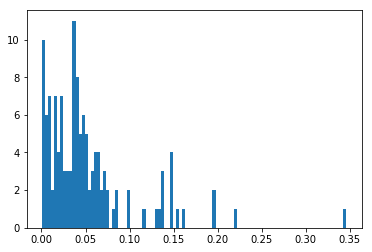

In [283]:
plt.hist(tar,bins=100)

In [284]:
p=model.predict_on_batch(DataGenerator(train_.values,batch_size=128).__getitem__(1)[0])

In [286]:
p

array([[0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],
       [0.0060504],


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0., 128.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([-0.4939496, -0.4839496, -0.4739496, -0.4639496, -0.4539496,
        -0.4439496, -0.4339496, -0.4239496, -0.4139496, -0.4039496,
        -0.3939496, -0.3839496, -0.3739496, -0.3639496, -0.3539496,
        -0.3439496, -0.3339496, -0.3239496, -0.3139496, -0.3039496,
        -0.2939496, -0.2839496, -0.2739496, -0

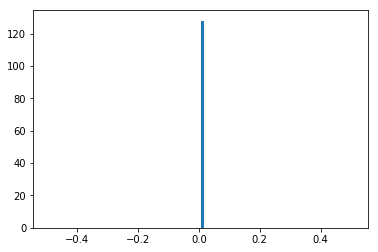

In [285]:
plt.hist(p,bins=100)

In [172]:
DataGenerator(train_.values,batch_size=128).__getitem__(1)[0]

{'authorized_flag': array([[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [2., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]]),
 'city_id_x': array([[ 13.,  13.,  13., ...,   0.,   0.,   0.],
        [ 31.,  31.,  31., ...,   0.,   0.,   0.],
        [ 34.,  34.,  34., ...,   0.,   0.,   0.],
        ...,
        [  4.,   4.,   4., ...,   0.,   0.,   0.],
        [227., 227., 227., ...,   0.,   0.,   0.],
        [ 36.,  51.,  51., ...,   0.,   0.,   0.]]),
 'category_1_x': array([[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [2., 2., 2., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]]),
 'installments': array([[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0., 128.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([-0.0564903, -0.0464903, -0.0364903, -0.0264903, -0.0164903,
        -0.0064903,  0.0035097,  0.0135097,  0.0235097,  0.0335097,
         0.0435097,  0.0535097,  0.0635097,  0.0735097,  0.0835097,
         0.0935097,  0.1035097,  0.1135097,  0.1235097,  0.1335097,
         0.1435097,  0.1535097,  0.1635097,  0

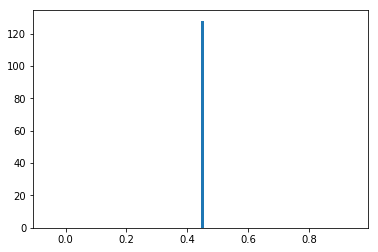

In [171]:
plt.hist(p,bins=100)

In [102]:
#OMFG IT WILL PREDICT WITH THE SECODN ELEMENT TOO -_- THATS WHY IT DOESNT WORK WHy DESNT IT TROW AN ERROR :D 
p= model.predict_generator(DataGenerator(train_.values,batch_size=128))

In [105]:
gen=DataGenerator(train_.values,batch_size=128)

In [106]:
gen=gen.__getitem__(0)

([array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 0., 0.

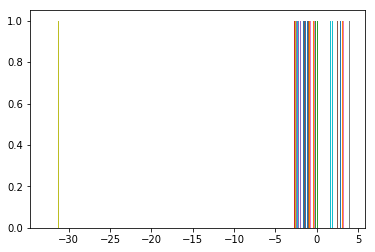

In [108]:
plt.hist(gen[1])

In [109]:
p=model.predict_on_batch(gen[0])

In [110]:
p

array([[1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],


In [107]:
gen[1]

array([1.17970712, -0.59307955, 0.16138047, -1.02358033, 0.72085919,
       -1.56206207, -0.03257177, -0.97585561, -0.87989513, -1.52836318,
       -0.27248764, 0.73829965, 0.056369, -0.64080623, 0.57006301,
       0.48033128, -0.24592744, -1.0039072, -0.34491858, -1.07494031,
       -0.29199853, 0.64488668, 1.08708155, 0.30045171, -0.91096474,
       0.17825196, -0.76909514, -1.93057446, -0.96365456, 2.69796616,
       0.47320357, -2.40548952, -1.84588387, -0.99314208, 0.40529465,
       -2.84359738, -0.33089665, 0.03974449, -1.13837353, 1.18218495,
       -1.3223314, -0.17282205, 0.10586757, 0.70978777, -0.79251933,
       1.41247094, -0.32435237, 0.876975, 0.26313959, -0.55600449,
       0.54502777, -1.3047035, -0.41298143, -0.63650833, 0.20410917,
       -0.00240116, 0.33387318, -0.29648087, 3.44345043, -1.8366812,
       -0.26082402, 1.71508645, -0.94467137, 0.22724483, 0.36603418,
       0.73584694, -1.35533089, -0.1043807, -33.21928095, -0.3610513,
       0.24779797, 0.49507317,

In [103]:
#np.unique(p)
p[1:100]

array([[1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],
       [1.1797072],


In [67]:
np.median(train_["target"])

-0.02390427

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0., 151424.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

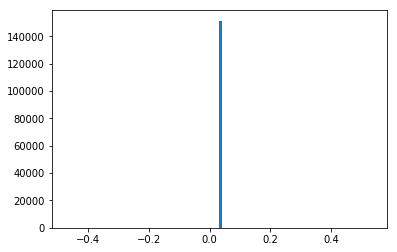

In [283]:
plt.hist(p,bins=100)

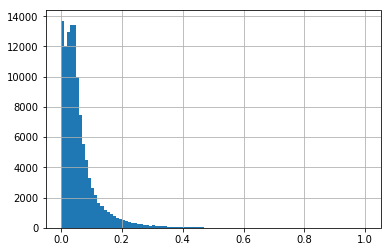

In [399]:
train["target"].hist(bins=100)

In [400]:
np.median(train["target"])

0.04360737314054361